In [1]:
import numpy as np
import torch
from itertools import product
from scipy import stats
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

TODO List:
- Added a convergence criterion for cases with explicit weight decay regularization.
- Added the `Groups` class which can handle imbalance sampling from groups.

In [155]:
# Linear regression
num_samples = 100       # per group (total = num_samples * num_groups)
num_features = 700
num_groups = 3

np.random.seed(42)
noise_level = 50
true_beta = np.random.randn( num_features, 1 ) # does not include the identifier weight.

In [156]:
def fully_structured_covariance(d):
    return np.diag( np.random.uniform(0.3, 4, size = d) ** 2 )

def identity_covariance(d):
    return np.identity( d )

class Group:

    ID = 0

    def __init__(self, covariance_generator = lambda: identity_covariance(num_features) ):
        self.id = Group.ID + 1
        Group.ID += 1

        self.cov = covariance_generator()
        self.x_dist = stats.multivariate_normal( cov = self.cov )

        self.x = None
        self.y = None
    
    # Generates X (input vars) 
    def _generate_x(self, n_samples, ID = False , **kwargs):
        x = self.x_dist.rvs(size= n_samples, **kwargs)
        if ID:
            identifier = np.repeat( self.ID , repeats=n_samples)
            x = np.column_stack( (identifier, x))
        return x
    
    # Generates (X, y) pairs according to linear model
    def generate(self, n_samples, beta = true_beta):
        x = self._generate_x(n_samples)
        y = np.dot(x, beta) + noise_level * np.random.randn(n_samples, 1)
        self.data = [x, y]
    
    @property
    def data(self):
        return self.x, self.y
    
    @data.setter
    def data(self, value):
        x, y = value # unpack
        self.x = torch.tensor(x, dtype = torch.float32, requires_grad=False)
        self.y = torch.tensor(y, dtype = torch.float32, requires_grad=False)

# Create the data
cov_generator = lambda: fully_structured_covariance(num_features)
groups = [ Group(cov_generator) for _ in range(num_groups) ]

# TODO: by this data generating process, we have equal number of groups in the
# training data, all disjoint. should we change this up (vary # of samples/gp)?
Data = {}
for group in groups:
    group.generate(num_samples, beta=true_beta)

    def __init__(self, num_groups, cov_generator = identity_covariance):

        Group.ID = 0
        self.groups = [ Group(cov_generator) for _ in range(num_groups) ]

        weights = self.WEIGHT_HANDLER(size = num_groups)
        weights /= weights.sum()
        self.weights = weights

        self.x , self.y = None, None
          
    
    def __iter__(self):
        return self.groups.__iter__()
    
    def __getitem__(self, index):
        return self.groups[index]

    def generate(self, n_samples, beta = true_beta):

        for group in self.groups:
            # Determine number of samples for this group
            n_group = self._get_nsample(n_samples, group)

            # Create the data for that specific group
            x = group._generate_x(n_group)
            y = np.dot(x, beta) + noise_level * np.random.randn(n_group, 1)
            
            group.data = [x, y]
    
    def _get_nsample(self, n, group):
        weights = self.weights
        weights = (weights * n).astype(int)
        weights[-1] = n - weights[:-1].sum()
        return int(weights[group.id])

    
    @property
    def data(self):
        if self.x is None:
            self.x = torch.cat( [ group.x for group in self.groups ], dim = 0 )
            self.y = torch.cat( [ group.y for group in self.groups ], dim = 0 )
        return self.x, self.y

    @data.setter
    def data(self,value):
        raise AttributeError("Can't assign data to this object.")
    

In [157]:

class LinearModel(torch.nn.Module):

    def __init__(self, input_dimension, **kwargs) -> None:
        super(LinearModel, self).__init__()
        # Initialize at zero. 
        self.linear = torch.nn.Linear( input_dimension, 1, bias = False, **kwargs )
        self._initialize(0.0)
    
    @classmethod
    def from_vector(cls, weights):
        weights = torch.as_tensor(weights).reshape((1,-1))
        input_dimension = weights.shape[1]
        obj = cls(input_dimension)
        obj.load_state_dict( {'linear.weight': weights} )
        return obj 
    
    @torch.no_grad()
    def _initialize(self, value):
        self.linear.weight.fill_(value)
        if self.linear.weight.grad is not None:
            self.linear.weight.grad.detach_()
            self.linear.weight.grad.zero_()
    
    # forward passes should NOT come from calling this directly!
    # i.e. model(x) instead of model.forward(x)
    def forward(self, x):
        out = self.linear(x)
        return out
    
    # by default, MSELoss divides by n, the size of sample
    def risk(self, x, y):
        loss = torch.nn.MSELoss()
        mse = loss( self(x) , y )
        return mse

        
    
# training loop (gradient descent on the balanaced risk: lmbd * std + dro)
def optimize_GD(model, X, Y, groups, trade_regularization = 0.1, beta_regularization = 0, max_iter = 5000, lr = 1e-3, weight_decay = 0.0):
    lmbd = torch.tensor([trade_regularization], requires_grad=False)
    eta = torch.tensor([beta_regularization], requires_grad=False)  # explicit regularizer for beta
    optimizer = torch.optim.SGD( params = model.parameters(), lr = lr, weight_decay = weight_decay )

    flag = True         # for convergence criterion (objective low enough)
    iteration = 0
    prev_params = model.linear.weight.data.numpy().copy()
    prev_objective = np.inf

    while flag and iteration < max_iter:
        optimizer.zero_grad()

        standard_risk = model.risk( X, Y )
        adversarial_risk = torch.max( torch.stack( [ model.risk(group.x, group.y) for group in groups ] ) )
        objective = lmbd * standard_risk + (1-lmbd) * adversarial_risk + eta * torch.norm(model.linear.weight)

        objective.backward()
        optimizer.step()

        # Check convergence based on parameter change. 
        relative_parameter_error = np.linalg.norm( prev_params - model.linear.weight.data.numpy() ) / np.linalg.norm( model.linear.weight.data.numpy() )
        relative_objective_error = np.abs( prev_objective - objective.item() ) 
        if relative_parameter_error < 1e-6 + weight_decay:
            flag = False
        
        if iteration % 100 == 0 and verbose:
            print(f" Objective loss is {objective.item():.4f} = {lmbd_std.item():.2f} * { standard_risk.item():.4f} + {lmbd_adv.item():.2f} * {adversarial_risk.item():.4f}")
            #print(f" Relative parameter error is {relative_parameter_error}")
        iteration += 1
        
        prev_params = model.linear.weight.data.numpy().copy()
        prev_objective = objective.item()
    
    # Final round printing
    if verbose:
        print(f" Objective loss is {objective.item():.4f} = {lmbd_std.item():.2f} * { standard_risk.item():.4f} + {lmbd_adv.item():.2f} * {adversarial_risk.item():.4f} at iteration {iteration}")
        print(f" Relative parameter error is {relative_parameter_error}")
    
    if iteration == max_iter:
        print("Maximum iteration reached.")

In [158]:
# Create the data
cov_generator = lambda: fully_structured_covariance(num_features)
groups = Groups(num_groups, cov_generator)

# TODO: by this data generating process, we have equal number of groups in the
# training data, all disjoint. should we change this up (vary # of samples/gp)?
groups.generate(num_samples, beta= true_beta)

X , Y = groups.data

# Solve the weighted regression problem using vanilla GD
lmbd = torch.tensor([0.1], requires_grad=False)
max_iter = 2000

model = LinearModel(num_features)
optimize_GD(model, X, Y, groups, trade_regularization = 1e2, weight_decay=1e-5, lr=1e-3, max_iter= max_iter, verbose=True)

 Objective loss is 6927.5703 = 0.01 * 6449.5576 + 1.00 * 6863.0747
 Objective loss is 335.7450 = 0.01 * 311.5579 + 1.00 * 332.6294
 Objective loss is 90.3336 = 0.01 * 83.9746 + 1.00 * 89.4938
 Objective loss is 30.6434 = 0.01 * 29.8353 + 1.00 * 30.3450
 Objective loss is 12.5689 = 0.01 * 12.0323 + 1.00 * 12.4486
 Objective loss is 5.3472 = 0.01 * 5.2386 + 1.00 * 5.2948
 Objective loss is 2.6138 = 0.01 * 2.4110 + 1.00 * 2.5897
 Objective loss is 1.1734 = 0.01 * 1.1506 + 1.00 * 1.1619
 Objective loss is 0.5789 = 0.01 * 0.5678 + 1.00 * 0.5733
 Objective loss is 0.3001 = 0.01 * 0.2872 + 1.00 * 0.2972
 Objective loss is 0.1579 = 0.01 * 0.1481 + 1.00 * 0.1564
 Objective loss is 0.0813 = 0.01 * 0.0778 + 1.00 * 0.0805
 Objective loss is 0.0446 = 0.01 * 0.0413 + 1.00 * 0.0442
 Objective loss is 0.0232 = 0.01 * 0.0221 + 1.00 * 0.0230
 Objective loss is 0.0124 = 0.01 * 0.0120 + 1.00 * 0.0122
 Objective loss is 0.0068 = 0.01 * 0.0065 + 1.00 * 0.0068
 Objective loss is 0.0038 = 0.01 * 0.0036 + 1.00

In [159]:
# OLS
ols_beta = torch.linalg.lstsq( X, Y ).solution

# Subgroups- OLS
subgroup_beta = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ]

In [160]:
import pandas as pd
import matplotlib.pyplot as plt

betas = np.hstack( [model.linear.weight.data.numpy().T, ols_beta.data.numpy()] + [beta.data.numpy() for beta in subgroup_beta ] )
betas = pd.DataFrame( betas, columns=["model", "OLS"] + [f"Group {i} OLS" for i in range(num_groups)] )

In [161]:
betas.corr()

true_beta     model       OLS  Group 0 OLS  Group 1 OLS  \
true_beta     1.000000  0.457325  0.457235     0.279996     0.317361   
model         0.457325  1.000000  0.999999     0.550505     0.529001   
OLS           0.457235  0.999999  1.000000     0.550383     0.528905   
Group 0 OLS   0.279996  0.550505  0.550383     1.000000     0.065774   
Group 1 OLS   0.317361  0.529001  0.528905     0.065774     1.000000   
Group 2 OLS   0.250908  0.410815  0.410732     0.046343     0.017719   

             Group 2 OLS  
true_beta       0.250908  
model           0.410815  
OLS             0.410732  
Group 0 OLS     0.046343  
Group 1 OLS     0.017719  
Group 2 OLS     1.000000

## Experiment 1: Varying $\lambda$ Tradeoff Parameter
Our notion of tradeoff risk between DRO and standard risk is controlled by the parameter $\lambda$. Fully writing out the
tradeoff objective, we have:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda) := \mathcal{R}_{\mathrm{group}}(\beta) + \lambda \mathcal{R}_{\mathrm{std}}(\beta)
= \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \lambda \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right],
$$
where $\mathbb{P}_g$ is the group distribution for group $g \in \mathcal{G}$. The $\lambda$ parameter controls how much we tradeoff for standard risk in our objective. $\lambda = 0$ means we are solely optimizing for group DRO. We vary the value of $\lambda$ and see if this has any effect on the resulting $\hat{\beta}$ that our model produces by minimizing $\hat{\mathcal{R}}_{\mathrm{trade}}$


In [162]:
import matplotlib.pyplot as plt

max_iter = 2000
lambdas = torch.tensor(np.linspace(0, 1.0), requires_grad=False)
ols_beta = torch.linalg.lstsq( X, Y ).solution  # regular OLS solution
subgroup_betas = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ] # OLS for each group
model_betas = list()
bookkeep = list()

for lmbd in lambdas:
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, X, Y, groups, trade_regularization = lmbd, lr = 1e-3,max_iter= max_iter, verbose=True)
    model_betas.append(model.linear.weight.data.numpy().T)

    # Calculate stats
    bookkeep.append([ model.risk(group.x, group.y).item() for group in groups ])

 Objective loss is 6449.6262 = 1.00 * 6449.5576 + 0.00 * 6863.0747
 Objective loss is 329.5767 = 1.00 * 329.5731 + 0.00 * 356.7617
 Objective loss is 90.5509 = 1.00 * 90.5499 + 0.00 * 95.8678
 Objective loss is 32.7942 = 1.00 * 32.7938 + 0.00 * 34.4229
 Objective loss is 13.4462 = 1.00 * 13.4460 + 0.00 * 14.1162
 Objective loss is 5.9448 = 1.00 * 5.9447 + 0.00 * 6.1796
 Objective loss is 2.7717 = 1.00 * 2.7717 + 0.00 * 2.8683
 Objective loss is 1.3452 = 1.00 * 1.3452 + 0.00 * 1.4128
 Objective loss is 0.6736 = 1.00 * 0.6736 + 0.00 * 0.7151
 Objective loss is 0.3458 = 1.00 * 0.3458 + 0.00 * 0.3699
 Objective loss is 0.1810 = 1.00 * 0.1810 + 0.00 * 0.1948
 Objective loss is 0.0963 = 1.00 * 0.0963 + 0.00 * 0.1040
 Objective loss is 0.0519 = 1.00 * 0.0519 + 0.00 * 0.0562
 Objective loss is 0.0283 = 1.00 * 0.0283 + 0.00 * 0.0307
 Objective loss is 0.0155 = 1.00 * 0.0155 + 0.00 * 0.0169
 Objective loss is 0.0086 = 1.00 * 0.0086 + 0.00 * 0.0094
 Objective loss is 0.0048 = 1.00 * 0.0048 + 0.00

Text(0.5, 0, '$\\lambda$')

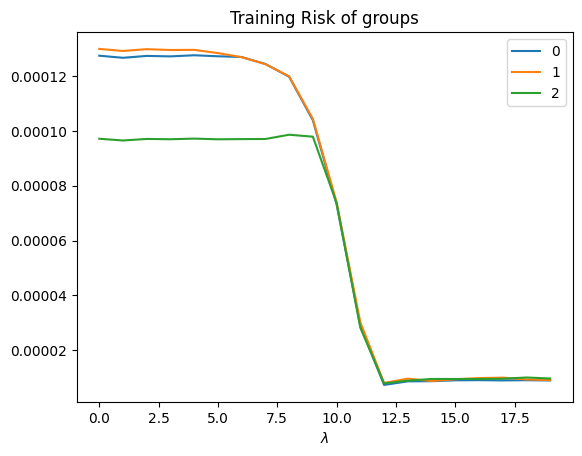

In [163]:
bookkeep = pd.DataFrame(bookkeep)
bookkeep.plot.line()

plt.title("Training Risk of groups")
plt.xlabel(r'$\lambda$')

Text(0, 0.5, '$\\frac{\\| \\beta_{\\mathrm{trade}} - \\beta_{\\mathrm{OLS}} \\|_2}{ \\| \\beta_{\\mathrm{OLS}} \\|_2 }$')

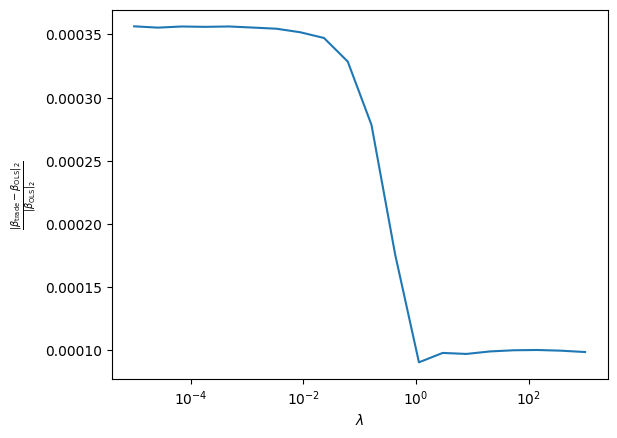

In [164]:
# Plot difference between model's betas and OLS beta
# Is this actually a significant difference?
beta_l2 = [np.linalg.norm(model_beta - ols_beta.numpy()) / np.linalg.norm(ols_beta.numpy()) for model_beta in model_betas]
plt.plot(lambdas, beta_l2)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\frac{\| \beta_{\mathrm{trade}} - \beta_{\mathrm{OLS}} \|_2}{ \| \beta_{\mathrm{OLS}} \|_2 }$')

Upshot: **they're the same!**

## Experiment 2: Adding Explicit Regularizer ($\eta\|\beta\|^2$) for different $\lambda$
Now, we add an explicit $\ell_2$ regularization to the objective, controlled by $\eta > 0.$ This gives us the objective:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda; \eta)
= (1 - \lambda) \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \lambda \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right] + \eta\|\beta\|_2,
$$
where we vary $\lambda \in [0, 1]$. Again, we denote the $\beta$ that we get from running GD on $\mathcal{R}_{\mathrm{trade}}(\beta; \lambda)$ as $\beta_{\mathrm{trade}}$. We denote the OLS solution as $\beta_{\mathrm{OLS}}$. For $\lambda = 1$, the $\mathcal{R}_{\mathrm{trade}}$ objective is equivalent to ridge regression, which we also compare to for the same values of $\eta$.

In [165]:
max_iter = np.inf
etas = np.logspace(-5,2, 20)
model_betas = list()
bookkeep = list()

# Fix lambda regularizer to 0.1, vary lambdas
for eta in tqdm(etas):
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, X , Y, groups, trade_regularization = 1e5, weight_decay = eta, max_iter= max_iter)
    model_betas.append(model.linear.weight.data.numpy().T)

    # Calculate stats
    bookkeep.append([ model.risk(group.x, group.y).item() for group in groups ])

100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


Text(0.5, 0, '$\\lambda$')

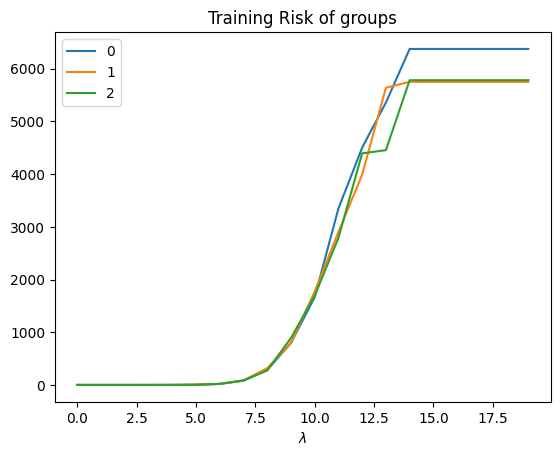

In [166]:
bookkeep = pd.DataFrame(bookkeep)
bookkeep.plot.line()

plt.title("Training Risk of groups")
plt.xlabel(r'$\lambda$')

Text(0, 0.5, '$\\frac{\\| \\beta_{\\mathrm{trade}} - \\beta_{\\mathrm{OLS}} \\|_2}{ \\| \\beta_{\\mathrm{OLS}} \\|_2 }$')

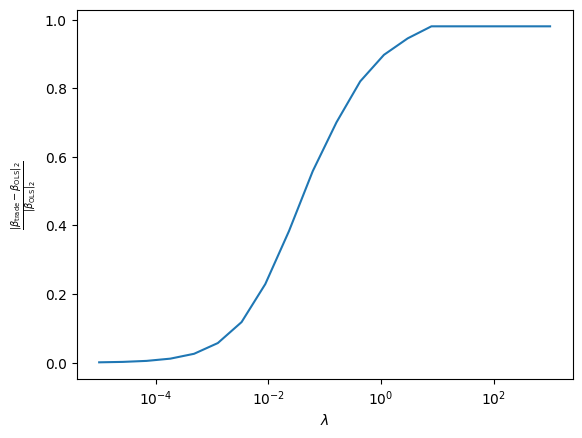

In [170]:
# Plot difference between model's betas and OLS beta
# Is this actually a significant difference?
beta_l2 = [np.linalg.norm(model_beta - ols_beta.numpy()) / np.linalg.norm(ols_beta.numpy()) for model_beta in model_betas]
plt.plot(lambdas, beta_l2)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\frac{\| \beta_{\mathrm{trade}} - \beta_{\mathrm{OLS}} \|_2}{ \| \beta_{\mathrm{OLS}} \|_2 }$')

Text(0, 0.5, '$\\frac{\\| \\beta_{\\mathrm{trade}} - \\beta_* \\|_2}{ \\| \\beta_* \\|_2 }$')

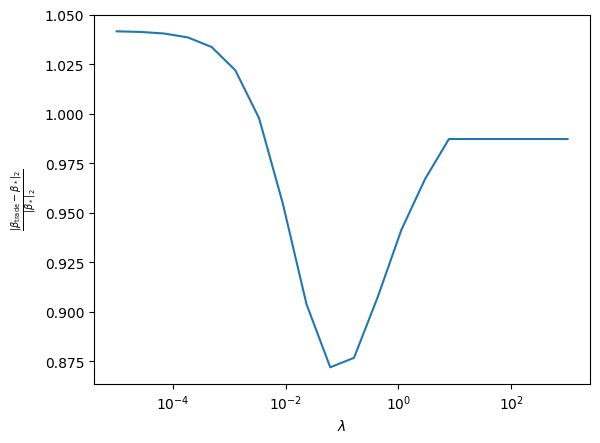

In [171]:

beta_l2 = [np.linalg.norm(model_beta - true_beta) / np.linalg.norm(true_beta) for model_beta in model_betas]
plt.plot(lambdas, beta_l2)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\frac{\| \beta_{\mathrm{trade}} - \beta_* \|_2}{ \| \beta_* \|_2 }$')

In [169]:
betas = np.hstack( [true_beta, ols_beta.data.numpy()] + model_betas )
betas = pd.DataFrame( betas, columns=["true_beta", "OLS"] + [f"Eta regularization = {eta}" for eta in etas] )
beta_melt = betas.melt( id_vars = ["true_beta"], value_vars= betas.columns[1:], var_name="beta_type" )


#sns.relplot(data = beta_melt, x = "true_beta", y = "value", col = "beta_type", col_wrap=2)
#sns.scatterplot( data = betas.set_index("true_beta"))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
